In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 20
lead_time = 2
filename = '../../../data/Arctic_Monthy_Mean_1979_2021.csv'

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Reading the dataset
df = pd.read_csv(filename)
df.head()

Date  wind_10m  specific_humidity     LW_down     SW_down  rainfall  \
0  1/1/1979  5.531398           0.811961  186.687054    3.127880  1.009872   
1  2/1/1979  5.328020           0.688896  174.794571   18.541594  0.920831   
2  3/1/1979  5.432511           0.916124  190.741933   67.690429  0.983327   
3  4/1/1979  4.792836           1.272056  212.937925  156.223673  0.890723   
4  5/1/1979  4.819028           2.239776  253.690478  230.950833  1.201308   

   snowfall         sst         t2m  surface_pressure  sea_ice_extent  
0  0.892319  273.355237  250.388101        984.633032        15604191  
1  0.781347  273.121885  247.071202        983.980418        16378929  
2  0.855266  273.088099  252.954138        985.140468        16521089  
3  0.705203  273.126062  259.557456        989.314698        15561238  
4  0.688723  273.393551  269.375118        984.483658        14085613

In [4]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.set_index('Date', inplace=True)
df = df.astype(float)                 # cast df to float
df.tail(len(df))

wind_10m  specific_humidity     LW_down     SW_down  rainfall  \
Date                                                                        
1979-01-01  5.531398           0.811961  186.687054    3.127880  1.009872   
1979-02-01  5.328020           0.688896  174.794571   18.541594  0.920831   
1979-03-01  5.432511           0.916124  190.741933   67.690429  0.983327   
1979-04-01  4.792836           1.272056  212.937925  156.223673  0.890723   
1979-05-01  4.819028           2.239776  253.690478  230.950833  1.201308   
...              ...                ...         ...         ...       ...   
2021-04-01  5.383687           1.529497  225.171796  156.567743  1.159049   
2021-05-01  4.777020           2.451088  260.956781  229.604138  1.077705   
2021-06-01  4.771453           4.176458  294.931709  244.702852  1.585094   
2021-07-01  4.754014           5.193846  313.311345  196.774631  1.957911   
2021-08-01  4.635243           5.077386  313.003568  126.146891  2.046782   

            snowfall         sst         t2m  surface_pressure  sea_ice_extent  
Date                                                                            
1979-01-01  0.892319  273.355237  250.388101        984.633032      15604191.0  
1979-02-01  0.781347  273.121885  247.071202        983.980418      16378929.0  
1979-03-01  0.855266  273.088099  252.954138        985.140468      16521089.0  
1979-04-01  0.705203  273.126062  259.557456        989.314698      15561238.0  
1979-05-01  0.688723  273.393551  269.375118        984.483658      14085613.0  
...              ...         ...         ...               ...             ...  
2021-04-01  0.929777  273.470298  263.146395        985.801841      13840000.0  
2021-05-01  0.575494  273.888627  271.557464        985.606182      12660000.0  
2021-06-01  0.360146  275.245088  278.360921        978.436682      10710000.0  
2021-07-01  0.248088  277.253314  280.413695        978.293303       7690000.0  
2021-08-01  0.235519  278.556142  279.556077        980.453507       5750000.0  

[512 rows x 10 columns]

In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + (lead_time-1)])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(*args, **kw)>

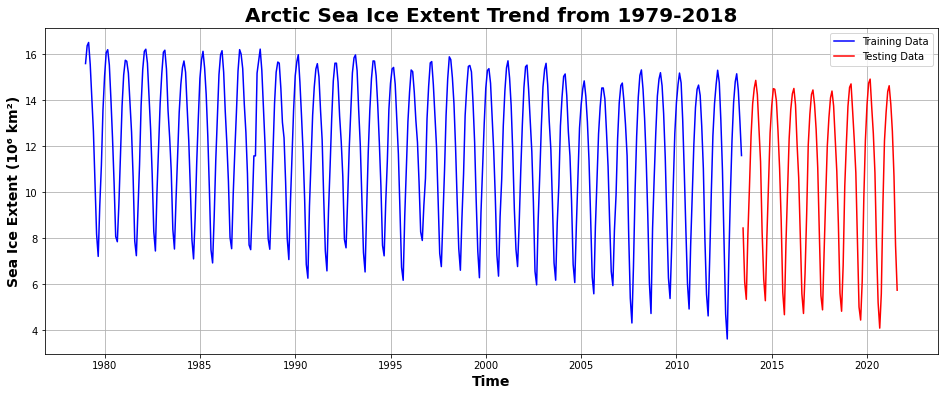

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(1024, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 64)            14592     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 20, 128)           74496     
                                                                 
 dropout_1 (Dropout)         (None, 20, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 20, 256)           296448    
                                                                 
 dropout_2 (Dropout)         (None, 20, 256)           0         
                                                                 
 gru_3 (GRU)                 (None, 20, 512)           1

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
5/6 [========================>.....] - ETA: 0s - loss: 0.7755 - mae: 0.6888 - mse: 0.7755

6/6 [==============================] - 19s 539ms/step - loss: 0.7245 - mae: 0.6634 - mse: 0.7245 - val_loss: 0.0914 - val_mae: 0.2736 - val_mse: 0.0914
Epoch 2/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0772 - mae: 0.2264 - mse: 0.0772

6/6 [==============================] - 0s 63ms/step - loss: 0.0767 - mae: 0.2271 - mse: 0.0767 - val_loss: 0.0692 - val_mae: 0.2327 - val_mse: 0.0692
Epoch 3/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0928 - mae: 0.2487 - mse: 0.0928

6/6 [==============================] - 0s 47ms/step - loss: 0.0913 - mae: 0.2463 - mse: 0.0913 - val_loss: 0.0796 - val_mae: 0.2290 - val_mse: 0.0796
Epoch 4/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0646 - mae: 0.2160 - mse: 0.0646

6/6 [==============================] - 0s 48ms/step - loss: 0.0672 - mae: 0.2201 - mse: 0.0672 - val_loss: 0.0831 - val_mae: 0.2256 - val_mse: 0.0831
Epoch 5/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0581 - mae: 0.1993 - mse: 0.0581

6/6 [==============================] - 0s 45ms/step - loss: 0.0576 - mae: 0.1991 - mse: 0.0576 - val_loss: 0.0658 - val_mae: 0.2135 - val_mse: 0.0658
Epoch 6/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0476 - mae: 0.1803 - mse: 0.0476

6/6 [==============================] - 0s 47ms/step - loss: 0.0464 - mae: 0.1783 - mse: 0.0464 - val_loss: 0.0210 - val_mae: 0.1197 - val_mse: 0.0210
Epoch 7/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0647 - mae: 0.2114 - mse: 0.0647

6/6 [==============================] - 0s 49ms/step - loss: 0.0652 - mae: 0.2139 - mse: 0.0652 - val_loss: 0.0715 - val_mae: 0.2342 - val_mse: 0.0715
Epoch 8/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0536 - mae: 0.1944 - mse: 0.0536

6/6 [==============================] - 0s 47ms/step - loss: 0.0517 - mae: 0.1906 - mse: 0.0517 - val_loss: 0.0608 - val_mae: 0.1998 - val_mse: 0.0608
Epoch 9/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0308 - mae: 0.1443 - mse: 0.0308

6/6 [==============================] - 0s 48ms/step - loss: 0.0298 - mae: 0.1411 - mse: 0.0298 - val_loss: 0.0282 - val_mae: 0.1329 - val_mse: 0.0282
Epoch 10/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0228 - mae: 0.1134 - mse: 0.0228

6/6 [==============================] - 0s 47ms/step - loss: 0.0221 - mae: 0.1124 - mse: 0.0221 - val_loss: 0.0176 - val_mae: 0.0970 - val_mse: 0.0176
Epoch 11/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0155 - mae: 0.0996 - mse: 0.0155

6/6 [==============================] - 0s 48ms/step - loss: 0.0153 - mae: 0.0988 - mse: 0.0153 - val_loss: 0.0161 - val_mae: 0.0981 - val_mse: 0.0161
Epoch 12/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0133 - mae: 0.0915 - mse: 0.0133

6/6 [==============================] - 0s 52ms/step - loss: 0.0137 - mae: 0.0922 - mse: 0.0137 - val_loss: 0.0300 - val_mae: 0.1568 - val_mse: 0.0300
Epoch 13/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0144 - mae: 0.0964 - mse: 0.0144

6/6 [==============================] - 0s 48ms/step - loss: 0.0143 - mae: 0.0956 - mse: 0.0143 - val_loss: 0.0291 - val_mae: 0.1317 - val_mse: 0.0291
Epoch 14/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0130 - mae: 0.0917 - mse: 0.0130

6/6 [==============================] - 0s 47ms/step - loss: 0.0133 - mae: 0.0920 - mse: 0.0133 - val_loss: 0.0185 - val_mae: 0.1049 - val_mse: 0.0185
Epoch 15/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0109 - mae: 0.0800 - mse: 0.0109

6/6 [==============================] - 0s 49ms/step - loss: 0.0109 - mae: 0.0801 - mse: 0.0109 - val_loss: 0.0189 - val_mae: 0.1043 - val_mse: 0.0189
Epoch 16/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0097 - mae: 0.0756 - mse: 0.0097

6/6 [==============================] - 0s 47ms/step - loss: 0.0093 - mae: 0.0740 - mse: 0.0093 - val_loss: 0.0184 - val_mae: 0.1096 - val_mse: 0.0184
Epoch 17/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0095 - mae: 0.0775 - mse: 0.0095

6/6 [==============================] - 0s 47ms/step - loss: 0.0094 - mae: 0.0772 - mse: 0.0094 - val_loss: 0.0167 - val_mae: 0.1057 - val_mse: 0.0167
Epoch 18/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0096 - mae: 0.0771 - mse: 0.0096

6/6 [==============================] - 0s 48ms/step - loss: 0.0095 - mae: 0.0771 - mse: 0.0095 - val_loss: 0.0107 - val_mae: 0.0767 - val_mse: 0.0107
Epoch 19/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0099 - mae: 0.0761 - mse: 0.0099

6/6 [==============================] - 0s 47ms/step - loss: 0.0097 - mae: 0.0760 - mse: 0.0097 - val_loss: 0.0142 - val_mae: 0.0900 - val_mse: 0.0142
Epoch 20/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0087 - mae: 0.0703 - mse: 0.0087

6/6 [==============================] - 0s 49ms/step - loss: 0.0088 - mae: 0.0711 - mse: 0.0088 - val_loss: 0.0114 - val_mae: 0.0774 - val_mse: 0.0114
Epoch 21/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0091 - mae: 0.0741 - mse: 0.0091

6/6 [==============================] - 0s 46ms/step - loss: 0.0088 - mae: 0.0726 - mse: 0.0088 - val_loss: 0.0241 - val_mae: 0.1319 - val_mse: 0.0241
Epoch 22/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0075 - mae: 0.0678 - mse: 0.0075

6/6 [==============================] - 0s 48ms/step - loss: 0.0078 - mae: 0.0697 - mse: 0.0078 - val_loss: 0.0090 - val_mae: 0.0673 - val_mse: 0.0090
Epoch 23/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0078 - mae: 0.0696 - mse: 0.0078

6/6 [==============================] - 0s 50ms/step - loss: 0.0080 - mae: 0.0700 - mse: 0.0080 - val_loss: 0.0216 - val_mae: 0.1293 - val_mse: 0.0216
Epoch 24/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0075 - mae: 0.0692 - mse: 0.0075

6/6 [==============================] - 0s 45ms/step - loss: 0.0077 - mae: 0.0700 - mse: 0.0077 - val_loss: 0.0098 - val_mae: 0.0727 - val_mse: 0.0098
Epoch 25/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0070 - mae: 0.0640 - mse: 0.0070

6/6 [==============================] - 0s 47ms/step - loss: 0.0069 - mae: 0.0639 - mse: 0.0069 - val_loss: 0.0115 - val_mae: 0.0795 - val_mse: 0.0115
Epoch 26/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0083 - mae: 0.0722 - mse: 0.0083

6/6 [==============================] - 0s 47ms/step - loss: 0.0082 - mae: 0.0718 - mse: 0.0082 - val_loss: 0.0134 - val_mae: 0.0865 - val_mse: 0.0134
Epoch 27/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0065 - mae: 0.0608 - mse: 0.0065

6/6 [==============================] - 0s 47ms/step - loss: 0.0068 - mae: 0.0624 - mse: 0.0068 - val_loss: 0.0074 - val_mae: 0.0612 - val_mse: 0.0074
Epoch 28/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0068 - mae: 0.0646 - mse: 0.0068

6/6 [==============================] - 0s 48ms/step - loss: 0.0068 - mae: 0.0643 - mse: 0.0068 - val_loss: 0.0175 - val_mae: 0.1069 - val_mse: 0.0175
Epoch 29/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0084 - mae: 0.0705 - mse: 0.0084

6/6 [==============================] - 0s 48ms/step - loss: 0.0086 - mae: 0.0724 - mse: 0.0086 - val_loss: 0.0109 - val_mae: 0.0749 - val_mse: 0.0109
Epoch 30/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0070 - mae: 0.0639 - mse: 0.0070

6/6 [==============================] - 0s 49ms/step - loss: 0.0070 - mae: 0.0630 - mse: 0.0070 - val_loss: 0.0131 - val_mae: 0.0855 - val_mse: 0.0131
Epoch 31/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0066 - mae: 0.0627 - mse: 0.0066

6/6 [==============================] - 0s 47ms/step - loss: 0.0067 - mae: 0.0629 - mse: 0.0067 - val_loss: 0.0060 - val_mae: 0.0556 - val_mse: 0.0060
Epoch 32/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0065 - mae: 0.0645 - mse: 0.0065

6/6 [==============================] - 0s 47ms/step - loss: 0.0067 - mae: 0.0651 - mse: 0.0067 - val_loss: 0.0146 - val_mae: 0.0939 - val_mse: 0.0146
Epoch 33/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0065 - mae: 0.0609 - mse: 0.0065

6/6 [==============================] - 0s 49ms/step - loss: 0.0066 - mae: 0.0619 - mse: 0.0066 - val_loss: 0.0087 - val_mae: 0.0637 - val_mse: 0.0087
Epoch 34/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0059 - mae: 0.0603 - mse: 0.0059

6/6 [==============================] - 0s 46ms/step - loss: 0.0057 - mae: 0.0588 - mse: 0.0057 - val_loss: 0.0110 - val_mae: 0.0746 - val_mse: 0.0110
Epoch 35/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0055 - mae: 0.0582 - mse: 0.0055

6/6 [==============================] - 0s 47ms/step - loss: 0.0057 - mae: 0.0592 - mse: 0.0057 - val_loss: 0.0066 - val_mae: 0.0694 - val_mse: 0.0066
Epoch 36/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0071 - mae: 0.0658 - mse: 0.0071

6/6 [==============================] - 0s 45ms/step - loss: 0.0072 - mae: 0.0655 - mse: 0.0072 - val_loss: 0.0079 - val_mae: 0.0650 - val_mse: 0.0079
Epoch 37/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0057 - mae: 0.0593 - mse: 0.0057

6/6 [==============================] - 0s 47ms/step - loss: 0.0057 - mae: 0.0587 - mse: 0.0057 - val_loss: 0.0098 - val_mae: 0.0717 - val_mse: 0.0098
Epoch 38/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0060 - mae: 0.0597 - mse: 0.0060

6/6 [==============================] - 0s 47ms/step - loss: 0.0059 - mae: 0.0592 - mse: 0.0059 - val_loss: 0.0072 - val_mae: 0.0536 - val_mse: 0.0072
Epoch 39/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0049 - mae: 0.0557 - mse: 0.0049

6/6 [==============================] - 0s 48ms/step - loss: 0.0049 - mae: 0.0558 - mse: 0.0049 - val_loss: 0.0066 - val_mae: 0.0629 - val_mse: 0.0066
Epoch 40/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0074 - mae: 0.0683 - mse: 0.0074

6/6 [==============================] - 0s 47ms/step - loss: 0.0072 - mae: 0.0676 - mse: 0.0072 - val_loss: 0.0055 - val_mae: 0.0561 - val_mse: 0.0055
Epoch 41/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0056 - mae: 0.0586 - mse: 0.0056

6/6 [==============================] - 0s 50ms/step - loss: 0.0055 - mae: 0.0583 - mse: 0.0055 - val_loss: 0.0074 - val_mae: 0.0612 - val_mse: 0.0074
Epoch 42/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0051 - mae: 0.0553 - mse: 0.0051

6/6 [==============================] - 0s 48ms/step - loss: 0.0049 - mae: 0.0543 - mse: 0.0049 - val_loss: 0.0095 - val_mae: 0.0668 - val_mse: 0.0095
Epoch 43/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0054 - mae: 0.0567 - mse: 0.0054

6/6 [==============================] - 0s 47ms/step - loss: 0.0054 - mae: 0.0567 - mse: 0.0054 - val_loss: 0.0067 - val_mae: 0.0672 - val_mse: 0.0067
Epoch 44/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0054 - mae: 0.0580 - mse: 0.0054

6/6 [==============================] - 0s 47ms/step - loss: 0.0054 - mae: 0.0578 - mse: 0.0054 - val_loss: 0.0103 - val_mae: 0.0877 - val_mse: 0.0103
Epoch 45/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0064 - mae: 0.0637 - mse: 0.0064

6/6 [==============================] - 0s 48ms/step - loss: 0.0064 - mae: 0.0631 - mse: 0.0064 - val_loss: 0.0076 - val_mae: 0.0592 - val_mse: 0.0076
Epoch 46/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0051 - mae: 0.0571 - mse: 0.0051

6/6 [==============================] - 0s 48ms/step - loss: 0.0052 - mae: 0.0571 - mse: 0.0052 - val_loss: 0.0069 - val_mae: 0.0614 - val_mse: 0.0069
Epoch 47/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0047 - mae: 0.0547 - mse: 0.0047

6/6 [==============================] - 0s 47ms/step - loss: 0.0046 - mae: 0.0545 - mse: 0.0046 - val_loss: 0.0022 - val_mae: 0.0332 - val_mse: 0.0022
Epoch 48/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0058 - mae: 0.0598 - mse: 0.0058

6/6 [==============================] - 0s 46ms/step - loss: 0.0058 - mae: 0.0600 - mse: 0.0058 - val_loss: 0.0089 - val_mae: 0.0623 - val_mse: 0.0089
Epoch 49/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0524 - mse: 0.0043

6/6 [==============================] - 0s 48ms/step - loss: 0.0044 - mae: 0.0526 - mse: 0.0044 - val_loss: 0.0024 - val_mae: 0.0334 - val_mse: 0.0024
Epoch 50/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0049 - mae: 0.0554 - mse: 0.0049

6/6 [==============================] - 0s 47ms/step - loss: 0.0049 - mae: 0.0557 - mse: 0.0049 - val_loss: 0.0050 - val_mae: 0.0492 - val_mse: 0.0050
Epoch 51/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0044 - mae: 0.0510 - mse: 0.0044

6/6 [==============================] - 0s 48ms/step - loss: 0.0044 - mae: 0.0512 - mse: 0.0044 - val_loss: 0.0077 - val_mae: 0.0712 - val_mse: 0.0077
Epoch 52/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0054 - mae: 0.0582 - mse: 0.0054

6/6 [==============================] - 0s 49ms/step - loss: 0.0055 - mae: 0.0584 - mse: 0.0055 - val_loss: 0.0088 - val_mae: 0.0670 - val_mse: 0.0088
Epoch 53/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0046 - mae: 0.0540 - mse: 0.0046

6/6 [==============================] - 0s 49ms/step - loss: 0.0048 - mae: 0.0555 - mse: 0.0048 - val_loss: 0.0072 - val_mae: 0.0618 - val_mse: 0.0072
Epoch 54/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0520 - mse: 0.0043

6/6 [==============================] - 0s 50ms/step - loss: 0.0042 - mae: 0.0515 - mse: 0.0042 - val_loss: 0.0081 - val_mae: 0.0639 - val_mse: 0.0081
Epoch 55/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0044 - mae: 0.0512 - mse: 0.0044

6/6 [==============================] - 0s 49ms/step - loss: 0.0042 - mae: 0.0504 - mse: 0.0042 - val_loss: 0.0085 - val_mae: 0.0697 - val_mse: 0.0085
Epoch 56/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0050 - mae: 0.0545 - mse: 0.0050

6/6 [==============================] - 0s 47ms/step - loss: 0.0049 - mae: 0.0541 - mse: 0.0049 - val_loss: 0.0069 - val_mae: 0.0658 - val_mse: 0.0069
Epoch 57/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0507 - mse: 0.0043

6/6 [==============================] - 0s 47ms/step - loss: 0.0042 - mae: 0.0504 - mse: 0.0042 - val_loss: 0.0043 - val_mae: 0.0435 - val_mse: 0.0043
Epoch 58/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0040 - mae: 0.0492 - mse: 0.0040

6/6 [==============================] - 0s 50ms/step - loss: 0.0039 - mae: 0.0488 - mse: 0.0039 - val_loss: 0.0047 - val_mae: 0.0508 - val_mse: 0.0047
Epoch 59/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0044 - mae: 0.0532 - mse: 0.0044

6/6 [==============================] - 0s 49ms/step - loss: 0.0044 - mae: 0.0531 - mse: 0.0044 - val_loss: 0.0021 - val_mae: 0.0329 - val_mse: 0.0021
Epoch 60/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0504 - mse: 0.0043

6/6 [==============================] - 0s 49ms/step - loss: 0.0043 - mae: 0.0509 - mse: 0.0043 - val_loss: 0.0037 - val_mae: 0.0483 - val_mse: 0.0037
Epoch 61/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0037 - mae: 0.0476 - mse: 0.0037

6/6 [==============================] - 0s 49ms/step - loss: 0.0036 - mae: 0.0467 - mse: 0.0036 - val_loss: 0.0031 - val_mae: 0.0363 - val_mse: 0.0031
Epoch 62/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0451 - mse: 0.0032

6/6 [==============================] - 0s 49ms/step - loss: 0.0032 - mae: 0.0449 - mse: 0.0032 - val_loss: 0.0023 - val_mae: 0.0311 - val_mse: 0.0023
Epoch 63/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0455 - mse: 0.0032

6/6 [==============================] - 0s 48ms/step - loss: 0.0033 - mae: 0.0457 - mse: 0.0033 - val_loss: 0.0023 - val_mae: 0.0349 - val_mse: 0.0023
Epoch 64/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0033 - mae: 0.0453 - mse: 0.0033

6/6 [==============================] - 0s 49ms/step - loss: 0.0033 - mae: 0.0452 - mse: 0.0033 - val_loss: 0.0027 - val_mae: 0.0363 - val_mse: 0.0027
Epoch 65/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0441 - mse: 0.0032

6/6 [==============================] - 0s 49ms/step - loss: 0.0033 - mae: 0.0446 - mse: 0.0033 - val_loss: 0.0030 - val_mae: 0.0398 - val_mse: 0.0030
Epoch 66/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0444 - mse: 0.0031

6/6 [==============================] - 0s 49ms/step - loss: 0.0031 - mae: 0.0440 - mse: 0.0031 - val_loss: 0.0039 - val_mae: 0.0442 - val_mse: 0.0039
Epoch 67/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0441 - mse: 0.0032

6/6 [==============================] - 0s 49ms/step - loss: 0.0034 - mae: 0.0447 - mse: 0.0034 - val_loss: 0.0022 - val_mae: 0.0385 - val_mse: 0.0022
Epoch 68/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0045 - mae: 0.0531 - mse: 0.0045

6/6 [==============================] - 0s 48ms/step - loss: 0.0044 - mae: 0.0528 - mse: 0.0044 - val_loss: 0.0059 - val_mae: 0.0577 - val_mse: 0.0059
Epoch 69/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0040 - mae: 0.0492 - mse: 0.0040

6/6 [==============================] - 0s 47ms/step - loss: 0.0040 - mae: 0.0488 - mse: 0.0040 - val_loss: 0.0013 - val_mae: 0.0234 - val_mse: 0.0013
Epoch 70/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0038 - mae: 0.0496 - mse: 0.0038

6/6 [==============================] - 0s 49ms/step - loss: 0.0037 - mae: 0.0488 - mse: 0.0037 - val_loss: 0.0052 - val_mae: 0.0521 - val_mse: 0.0052
Epoch 71/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0035 - mae: 0.0472 - mse: 0.0035

6/6 [==============================] - 0s 48ms/step - loss: 0.0033 - mae: 0.0462 - mse: 0.0033 - val_loss: 0.0012 - val_mae: 0.0250 - val_mse: 0.0012
Epoch 72/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0427 - mse: 0.0030

6/6 [==============================] - 0s 47ms/step - loss: 0.0030 - mae: 0.0433 - mse: 0.0030 - val_loss: 0.0028 - val_mae: 0.0371 - val_mse: 0.0028
Epoch 73/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0033 - mae: 0.0449 - mse: 0.0033

6/6 [==============================] - 0s 48ms/step - loss: 0.0033 - mae: 0.0449 - mse: 0.0033 - val_loss: 0.0019 - val_mae: 0.0326 - val_mse: 0.0019
Epoch 74/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0435 - mse: 0.0030

6/6 [==============================] - 0s 47ms/step - loss: 0.0030 - mae: 0.0436 - mse: 0.0030 - val_loss: 0.0027 - val_mae: 0.0435 - val_mse: 0.0027
Epoch 75/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0042 - mae: 0.0516 - mse: 0.0042

6/6 [==============================] - 0s 49ms/step - loss: 0.0041 - mae: 0.0506 - mse: 0.0041 - val_loss: 0.0069 - val_mae: 0.0763 - val_mse: 0.0069
Epoch 76/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0035 - mae: 0.0466 - mse: 0.0035

6/6 [==============================] - 0s 49ms/step - loss: 0.0035 - mae: 0.0466 - mse: 0.0035 - val_loss: 0.0015 - val_mae: 0.0256 - val_mse: 0.0015
Epoch 77/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0426 - mse: 0.0029

6/6 [==============================] - 0s 51ms/step - loss: 0.0031 - mae: 0.0439 - mse: 0.0031 - val_loss: 0.0036 - val_mae: 0.0419 - val_mse: 0.0036
Epoch 78/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0446 - mse: 0.0031

6/6 [==============================] - 0s 49ms/step - loss: 0.0031 - mae: 0.0445 - mse: 0.0031 - val_loss: 0.0033 - val_mae: 0.0455 - val_mse: 0.0033
Epoch 79/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0033 - mae: 0.0461 - mse: 0.0033

6/6 [==============================] - 0s 48ms/step - loss: 0.0033 - mae: 0.0464 - mse: 0.0033 - val_loss: 0.0023 - val_mae: 0.0386 - val_mse: 0.0023
Epoch 80/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0444 - mse: 0.0031

6/6 [==============================] - 0s 49ms/step - loss: 0.0031 - mae: 0.0447 - mse: 0.0031 - val_loss: 0.0046 - val_mae: 0.0533 - val_mse: 0.0046
Epoch 81/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0423 - mse: 0.0028

6/6 [==============================] - 0s 48ms/step - loss: 0.0029 - mae: 0.0436 - mse: 0.0029 - val_loss: 0.0013 - val_mae: 0.0247 - val_mse: 0.0013
Epoch 82/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0427 - mse: 0.0030

6/6 [==============================] - 0s 48ms/step - loss: 0.0029 - mae: 0.0420 - mse: 0.0029 - val_loss: 0.0024 - val_mae: 0.0352 - val_mse: 0.0024
Epoch 83/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0033 - mae: 0.0464 - mse: 0.0033

6/6 [==============================] - 0s 49ms/step - loss: 0.0032 - mae: 0.0456 - mse: 0.0032 - val_loss: 0.0040 - val_mae: 0.0565 - val_mse: 0.0040
Epoch 84/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0443 - mse: 0.0031

6/6 [==============================] - 0s 49ms/step - loss: 0.0031 - mae: 0.0446 - mse: 0.0031 - val_loss: 0.0017 - val_mae: 0.0309 - val_mse: 0.0017
Epoch 85/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0423 - mse: 0.0028

6/6 [==============================] - 0s 48ms/step - loss: 0.0030 - mae: 0.0432 - mse: 0.0030 - val_loss: 0.0041 - val_mae: 0.0571 - val_mse: 0.0041
Epoch 86/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0442 - mse: 0.0031

6/6 [==============================] - 0s 48ms/step - loss: 0.0029 - mae: 0.0433 - mse: 0.0029 - val_loss: 0.0047 - val_mae: 0.0602 - val_mse: 0.0047
Epoch 87/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0424 - mse: 0.0029

6/6 [==============================] - 0s 50ms/step - loss: 0.0028 - mae: 0.0417 - mse: 0.0028 - val_loss: 0.0046 - val_mae: 0.0592 - val_mse: 0.0046
Epoch 88/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0038 - mae: 0.0493 - mse: 0.0038

6/6 [==============================] - 0s 48ms/step - loss: 0.0036 - mae: 0.0482 - mse: 0.0036 - val_loss: 0.0072 - val_mae: 0.0776 - val_mse: 0.0072
Epoch 89/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0042 - mae: 0.0532 - mse: 0.0042

6/6 [==============================] - 0s 49ms/step - loss: 0.0040 - mae: 0.0518 - mse: 0.0040 - val_loss: 0.0026 - val_mae: 0.0395 - val_mse: 0.0026
Epoch 90/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0430 - mse: 0.0030

6/6 [==============================] - 0s 51ms/step - loss: 0.0030 - mae: 0.0432 - mse: 0.0030 - val_loss: 0.0024 - val_mae: 0.0325 - val_mse: 0.0024
Epoch 91/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0425 - mse: 0.0028

6/6 [==============================] - 0s 49ms/step - loss: 0.0028 - mae: 0.0428 - mse: 0.0028 - val_loss: 0.0031 - val_mae: 0.0416 - val_mse: 0.0031
Epoch 92/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0024 - mae: 0.0396 - mse: 0.0024

6/6 [==============================] - 0s 49ms/step - loss: 0.0024 - mae: 0.0396 - mse: 0.0024 - val_loss: 0.0015 - val_mae: 0.0279 - val_mse: 0.0015
Epoch 93/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0421 - mse: 0.0028

6/6 [==============================] - 0s 50ms/step - loss: 0.0028 - mae: 0.0421 - mse: 0.0028 - val_loss: 0.0036 - val_mae: 0.0468 - val_mse: 0.0036
Epoch 94/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0422 - mse: 0.0029

6/6 [==============================] - 0s 48ms/step - loss: 0.0028 - mae: 0.0419 - mse: 0.0028 - val_loss: 0.0021 - val_mae: 0.0347 - val_mse: 0.0021
Epoch 95/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0026 - mae: 0.0408 - mse: 0.0026

6/6 [==============================] - 0s 46ms/step - loss: 0.0025 - mae: 0.0398 - mse: 0.0025 - val_loss: 0.0042 - val_mae: 0.0577 - val_mse: 0.0042
Epoch 96/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0021 - mae: 0.0361 - mse: 0.0021

6/6 [==============================] - 0s 48ms/step - loss: 0.0021 - mae: 0.0365 - mse: 0.0021 - val_loss: 0.0029 - val_mae: 0.0457 - val_mse: 0.0029
Epoch 97/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0027 - mae: 0.0416 - mse: 0.0027

6/6 [==============================] - 0s 48ms/step - loss: 0.0026 - mae: 0.0409 - mse: 0.0026 - val_loss: 0.0022 - val_mae: 0.0363 - val_mse: 0.0022
Epoch 98/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0024 - mae: 0.0378 - mse: 0.0024

6/6 [==============================] - 0s 48ms/step - loss: 0.0023 - mae: 0.0377 - mse: 0.0023 - val_loss: 0.0035 - val_mae: 0.0476 - val_mse: 0.0035
Epoch 99/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0025 - mae: 0.0400 - mse: 0.0025

6/6 [==============================] - 0s 48ms/step - loss: 0.0024 - mae: 0.0388 - mse: 0.0024 - val_loss: 0.0024 - val_mae: 0.0395 - val_mse: 0.0024
Epoch 100/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0426 - mse: 0.0029

6/6 [==============================] - 0s 47ms/step - loss: 0.0029 - mae: 0.0427 - mse: 0.0029 - val_loss: 0.0033 - val_mae: 0.0479 - val_mse: 0.0033


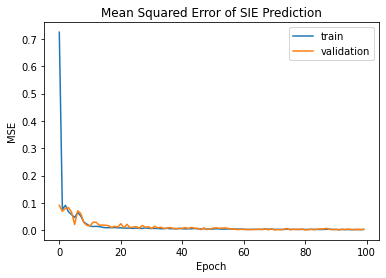

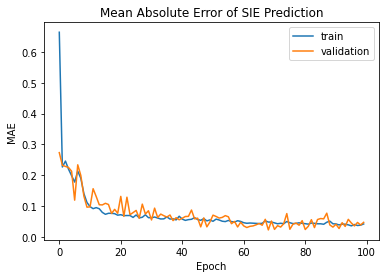

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

4/4 [==============================] - 2s 20ms/step


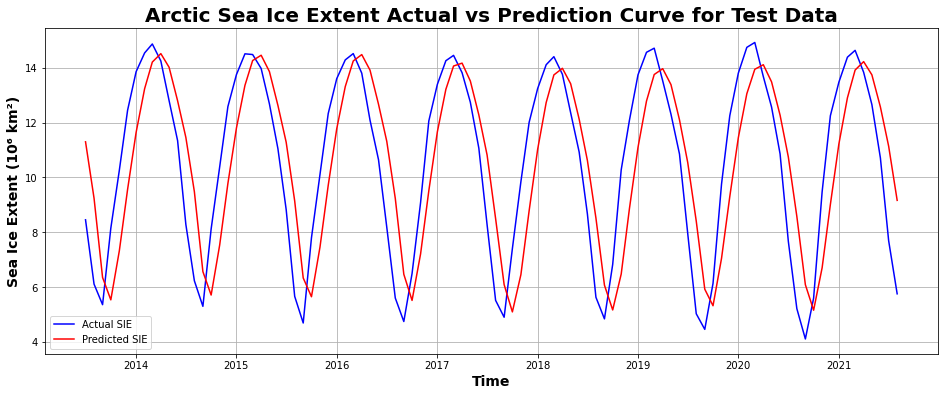

MSE :  4491203021640.209 (10⁶ km²)
MSPE : 7.334 %
RMSE :  2119245.861536648 (10⁶ km²)
RMSPE : 27.081 %
MAE :  1872365.6734693877 (10⁶ km²)
MAPE :  20.723 %
R2 :  49.85


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", round(mspe,3), "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", round(rmspe,3), "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", round(mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100,3), "%")
print("R2 : ", round(r2_score(predictions['predicted'].values, predictions['actual'].values)*100,3))

In [14]:
# while True:pass